In [1]:
%load_ext autoreload
%autoreload 2
from cs285.envs.pendulum.pendulum_env import PendulumEnv
from cs285.envs.dt_sampler import ConstantSampler
from cs285.infrastructure.replay_buffer import ReplayBufferTrajectories
from cs285.infrastructure.utils import sample_n_trajectories, RandomPolicy
from cs285.agents.ode_agent import ODEAgent
from typing import Callable, Optional, Tuple, Sequence
import numpy as np
import gym
from cs285.infrastructure import pytorch_util as ptu
from tqdm import trange
import jax
import jax.numpy as jnp
import equinox as eqx
import diffrax
from diffrax import diffeqsolve, Dopri5
import optax
import matplotlib.pyplot as plt
import wandb
import pprint
import pprint

In [2]:
key = jax.random.PRNGKey(0)
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
def test_true_dynamics_agent(agent, ntraj, plot=False):
    trajs, _ = sample_n_trajectories(agent.env, agent, ntraj=ntraj, max_length=200, key=key)
    rewards = [t["episode_statistics"]["r"] for t in trajs]
    if plot:
        plt.hist(rewards, bins=20)
    mean, std, min, max = np.mean(rewards), np.std(rewards), np.min(rewards), np.max(rewards)
    print("mean", mean)
    print("std", std)
    print("min", min)
    print("max", max)
    stats = {
        "mean": mean,
        "std": std,
        "min": min,
        "max": max
    }
    return rewards, stats

In [4]:
dt_sampler = ConstantSampler(dt=0.05)
env = PendulumEnv(
    dt_sampler=dt_sampler
)
mpc_dt_sampler = ConstantSampler(dt=0.05)
agent_key, key = jax.random.split(key)
neural_ode_name = "pendulum_true_dynamics"
neural_ode_kwargs = {
    "ode_dt0": 0.005,
}
optimizer_name = "adamw"
optimizer_kwargs = {"learning_rate": 1e-3}
mb_agent = ODEAgent(
    env=env,
    key=agent_key,
    neural_ode_name=neural_ode_name,
    neural_ode_kwargs=neural_ode_kwargs,
    optimizer_name=optimizer_name,
    optimizer_kwargs=optimizer_kwargs,
    ensemble_size=1,
    train_discount=1,
    mpc_horizon_steps=20,
    mpc_dt_sampler=mpc_dt_sampler,
    mpc_strategy="random",
    mpc_discount=0.95,
    mpc_num_action_sequences=1000,
    cem_num_iters=4,
    cem_num_elites=5,
    cem_alpha=1,
)

100%|██████████| 100/100 [02:41<00:00,  1.62s/it]

mean -1198.1469
std 276.66138
min -1839.6028
max -721.12476


([-1715.5911,
  -1075.523,
  -1256.1973,
  -1673.6987,
  -1793.1582,
  -1317.0759,
  -1070.4153,
  -1278.8779,
  -1353.1873,
  -992.12024,
  -1363.3391,
  -1072.8632,
  -1138.0256,
  -1346.6162,
  -1444.9705,
  -1159.9937,
  -1080.5519,
  -870.8106,
  -1080.271,
  -1740.8087,
  -1316.4354,
  -1297.7012,
  -1369.384,
  -1097.9888,
  -761.76904,
  -1785.231,
  -1638.9424,
  -1126.6602,
  -1072.7823,
  -1531.939,
  -1298.7985,
  -1072.0841,
  -1211.3765,
  -1099.9697,
  -876.459,
  -1183.5226,
  -901.4381,
  -873.0941,
  -1109.0576,
  -889.7103,
  -1073.5306,
  -1362.0928,
  -1596.7524,
  -765.11926,
  -1358.604,
  -1381.981,
  -1839.6028,
  -1140.6223,
  -970.66235,
  -866.9221,
  -1414.1278,
  -1369.7277,
  -1366.863,
  -869.23535,
  -777.3425,
  -1289.4082,
  -1167.5671,
  -1725.9231,
  -909.00366,
  -1067.5465,
  -1467.0972,
  -1289.7932,
  -1082.6465,
  -1170.4003,
  -1079.8466,
  -986.9471,
  -1100.6404,
  -1308.3818,
  -883.3982,
  -750.3158,
  -1169.0527,
  -1797.0911,
  -1419.682

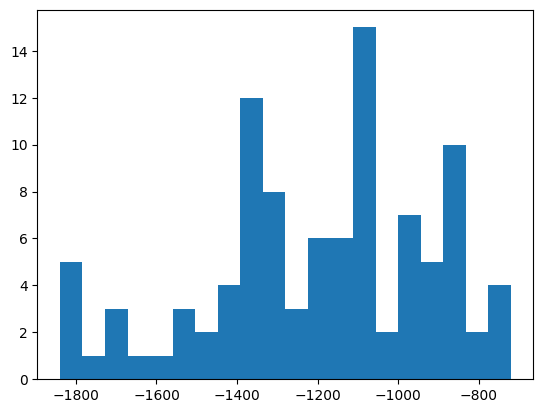

In [5]:
test_true_dynamics_agent(mb_agent, ntraj=100, plot=True)

In [9]:
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
wandb: Currently logged in as: zekai-wang. Use `wandb login --relogin` to force relogin
/home/zekai/miniconda3/envs/cs285_proj/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [11]:
sweep_config = {
    'method': 'random'
    }
metric = {
    'name': 'mean',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'mpc_horizon_steps': {
        'values': [1, 2, 5, 10, 20, 50, 100, 200]
        },
    'mpc_discount': {
        'values': [1.0, 0.99, 0.95, 0.9, 0.8, 0.5]
        },
    "mpc_num_action_sequences": {
        'values': [100, 200, 500, 1000, 2000, 5000]
        },
    'mpc_strategy': {
        'values': ["random", "cem"]
        },
    'cem_num_iters': {
        'values': [2, 4, 8, 16],
        },
    'cem_num_elites': {
        'values': [1, 2, 4, 8, 16, 32, 64],
        },
    'cem_alpha': {
        'values': [1.0, 0.99, 0.95, 0.9, 0.8, 0.5],
        },
    }

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)


{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'mean'},
 'parameters': {'cem_alpha': {'values': [1.0, 0.99, 0.95, 0.9, 0.8, 0.5]},
                'cem_num_elites': {'values': [1, 2, 4, 8, 16, 32, 64]},
                'cem_num_iters': {'values': [2, 4, 8, 16]},
                'mpc_discount': {'values': [1.0, 0.99, 0.95, 0.9, 0.8, 0.5]},
                'mpc_horizon_steps': {'values': [1,
                                                 2,
                                                 5,
                                                 10,
                                                 20,
                                                 50,
                                                 100,
                                                 200]},
                'mpc_num_action_sequences': {'values': [100,
                                                        200,
                                                        500,
                                     

In [12]:
sweep_id = wandb.sweep(sweep_config, project="cs285_proj_get_action_true_dynamics_updated")

Create sweep with ID: ok4muk7m
Sweep URL: https://wandb.ai/zekai-wang/cs285_proj_get_action_true_dynamics_updated/sweeps/ok4muk7m


In [13]:
key = jax.random.PRNGKey(0)

In [14]:
def evaluate(config=None):
    with wandb.init(config=config):
        config = wandb.config
        dt_sampler = ConstantSampler(dt=0.05)
        env = PendulumEnv(
            dt_sampler=dt_sampler
        )
        mpc_dt_sampler = ConstantSampler(dt=0.05)
        neural_ode_name = "pendulum_true_dynamics"
        neural_ode_kwargs = {
            "ode_dt0": 0.005,
        }
        optimizer_name = "adamw"
        optimizer_kwargs = {"learning_rate": 1e-3}
        agent = ODEAgent(
            env=env,
            key=key,
            neural_ode_name=neural_ode_name,
            neural_ode_kwargs=neural_ode_kwargs,
            optimizer_name=optimizer_name,
            optimizer_kwargs=optimizer_kwargs,
            ensemble_size=1,
            train_discount=1,
            mpc_horizon_steps=config.mpc_horizon_steps,
            mpc_dt_sampler=mpc_dt_sampler,
            mpc_strategy=config.mpc_strategy,
            mpc_discount=config.mpc_discount,
            mpc_num_action_sequences=config.mpc_num_action_sequences,
            cem_num_iters=config.cem_num_iters,
            cem_num_elites=config.cem_num_elites,
            cem_alpha=config.cem_alpha,
        )
        rewards, stats = test_true_dynamics_agent(agent, ntraj=10)
        wandb.log({"rewards": rewards,
                   "min": stats["min"],
                   "max": stats["max"],
                   "mean": stats["mean"],
                   "std": stats["std"],})


In [15]:
wandb.agent(sweep_id, evaluate, count=100)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
